<a href="https://colab.research.google.com/github/Ziqi-Li/GIS5122/blob/main/assignments/GIS5122_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
**Due date/time:** Mar 29th Fri 23:59pm

**Instruction**: Make a copy of this notebook and read through the questions and instructions. Write down code/text to perform the analysis.

**Submission**: After you finish working on this notebook, click File->Download->Download .ipynb

Please submit a notebook named A4_your_name.ipynb on Canvas.

## Detailed instructions:

In this assignment, we will practice modeling spatial heterogeneity using geographically weighted regression models

**Note**: From this assignment and onward, if you are interested in performing your analysis using your own data (e.g., you may have a dataset from a research project), you are very encouraged to do so.

We will be re-using our data and model specifications from Assignment 3. For the same set of dependent variable (y) and independent variables (X):

1. Fit a GWR model and an MGWR model. Note, MGWR may take a while to finish. Also make sure you standardize your variables before model fitting. (2%)
2. Compare the models in terms of a) R², b) AICc, and c) spatial autocorrelation in the model residuals. Indicate which model performs better for your data. (2%)
3. Make maps of your spatially varying coefficients with adjustments for multiple testing (make insignificant coefficients grey). (3%)
4. Describe the spatial pattern you observe in your maps of spatially varying coefficients. Hints: Comment on the general pattern, magnitude, sign of the coefficients, and spatial scale of the relationship, etc. (3%)



In [5]:
pip install statsmodels.api

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodels.api (from versions: none)
ERROR: No matching distribution found for statsmodels.api


In [2]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from libpysal.weights import Queen
from esda.moran import Moran
#MGWR functions
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

Code to read in data and merge them into one final `GeoDataFrame`.

In [3]:
health_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/cdc_health_county.csv"
health = pd.read_csv(health_url)

In [4]:
socio_demo_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/acs_2019.csv"
socio_demo = pd.read_csv(socio_demo_url)

In [5]:
counties_url = "https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson"
counties = gpd.read_file(counties_url)

In [6]:
income_health = pd.merge(socio_demo, health, left_on = "county_id", right_on = "LocationID")

In [7]:
gdf_income_health = pd.merge(counties, income_health, on = "county_id")

# Fitting a GWR model

In [8]:
# Dependent variable
y_variable = gdf_income_health['OBESITY']


# Independent variables
variable_names = ['median_income', 'pct_black', 
                                    'pct_bach', 'sex_ratio', 'pct_65_over', 
                                    'ln_pop_den' ]


y = gdf_income_health[['OBESITY']].values

X = gdf_income_health[variable_names].values

In [9]:
# standardizing both the independent and the dependent variables
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

In [10]:
#coordinates to put into GWR
coords = gdf_income_health[['proj_X', 'proj_Y']].values

In [11]:
# Select the optimal bandwidths
gwr_selector = Sel_BW(coords, y, X)

gwr_bw = gwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  1219.0 , score:  5312.89
Bandwidth:  1938.0 , score:  5650.39
Bandwidth:  774.0 , score:  5009.67
Bandwidth:  499.0 , score:  4780.10
Bandwidth:  329.0 , score:  4641.16
Bandwidth:  224.0 , score:  4566.27
Bandwidth:  159.0 , score:  4527.30
Bandwidth:  119.0 , score:  4537.83
Bandwidth:  184.0 , score:  4539.75
Bandwidth:  144.0 , score:  4527.26
Bandwidth:  134.0 , score:  4527.90
Bandwidth:  149.0 , score:  4526.19
Bandwidth:  153.0 , score:  4525.86
Bandwidth:  155.0 , score:  4526.91
Bandwidth:  151.0 , score:  4525.88
Selected optimal bandwidth is: 153.0


In [12]:
#Fitting the GWR model using the optimal bw
gwr_results = GWR(coords, y, X, bw=gwr_bw,name_x=variable_names).fit()

In [13]:
#Summary of GWR outputs
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1324.351
Log-likelihood:                                                   -3081.946
AIC:                                                               6177.892
AICc:                                                              6179.939
BIC:                                                             -23567.875
R2:                                                                   0.573
Adj. R2:                                                              0.572

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [14]:
variable_names

['median_income',
 'pct_black',
 'pct_bach',
 'sex_ratio',
 'pct_65_over',
 'ln_pop_den']

In [14]:
gwr_results.params[:,4]

array([-0.13141718, -0.14603267, -0.06933608, ...,  0.0698775 ,
       -0.13874899,  0.03770032])

## joinning the GWR result with the county GeoDataFrame.

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False,figsize=(10, 10)):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    k = gwr_results.k
    
    fig, axs = plt.subplots(int(k/2)+1, 2, figsize=figsize)
    axs = axs.ravel()
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("bwr_r")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap=cmap,norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

## Residuals of from the GWR model.

In [16]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(gdf_income_health)

#row standardization
w.transform = 'R'

residual_moran = Moran(gwr_results.resid_response.reshape(-1), w)
residual_moran.I

C:\Users\jacob\AppData\Local\Temp\ipykernel_5264\2531743358.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_income_health)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


C:\Users\jacob\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


0.06484030589623976

### spatially varying coefficients with adjustments for multiple testing¶ for GWR model

Insinificant parameters are masked out in grey

C:\Users\jacob\AppData\Local\Temp\ipykernel_5264\1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


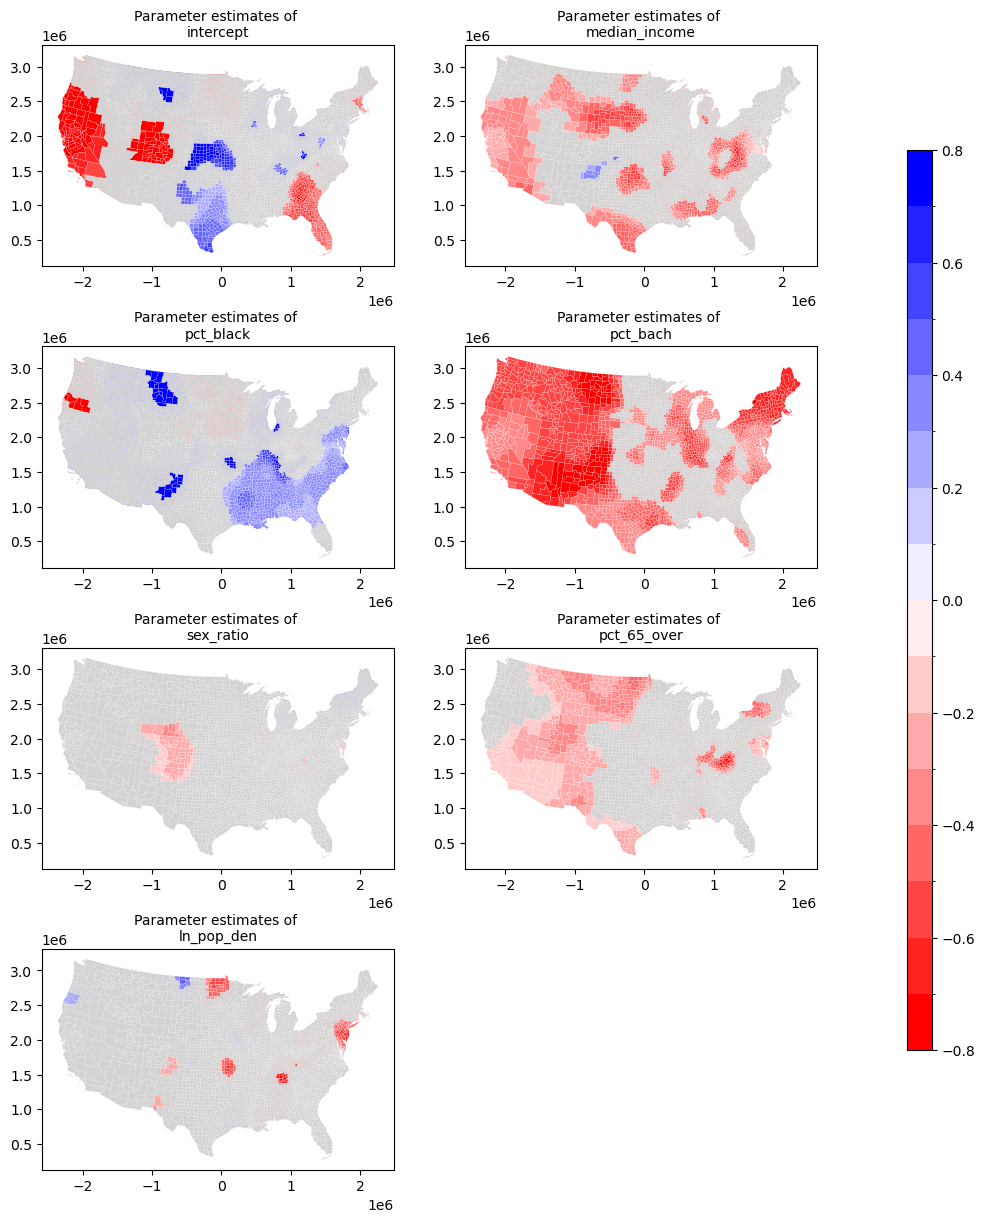

In [17]:
param_plots(gwr_results, gdf_income_health, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

From the maps, it is evident that there are varying relationships between obesity and socio-demographic variables in the USA, with these relationships exhibiting spatial clustering. For instance, while regions like Florida and Georgia demonstrate a weak, yet significant, negative relationship, areas such as California and parts of Nevada display a strong negative relationship. Conversely, regions like Texas and Nebraska exhibit a positive and significant relationship. Moreover, numerous parts of the USA exhibit an insignificant relationship between obesity and socio-demographic variables.

The maps reveal a significantly negative relationship between obesity and the percentage of individuals with bachelor's degrees, primarily in the western and northeastern regions of the US. This suggests that individuals with higher education levels are less likely to experience obesity. However, there is no observed positive relationship between the percentage of individuals with bachelor's degrees and obesity.

Furthermore, the analysis indicates a weak, yet significant, positive relationship between the percentage of Black individuals and obesity incidents in the southeastern region. Additionally, a strong positive relationship is observed in parts of Montana, while a very strong negative relationship is noted in certain areas of Oregon.

Additionally, the maps illustrate a weak negative relationship between the percentage of people over 65 years old and obesity, spanning from the southwestern to the northern regions.

A Moran's I value of 0.7 indicates a strong positive spatial autocorrelation, signifying that neighboring locations are highly correlated in terms of the variable.

# Fitting MGWR model

In [18]:
%%time
mgwr_selector = Sel_BW(coords, y, X,multi=True,n_jobs=-1)
mgwr_bw = mgwr_selector.search(verbose=True, max_iter_multi=20)

print("Selected optimal bandwidth is:", mgwr_bw)

Backfitting:   0%|          | 0/20 [00:00<?, ?it/s]

Current iteration: 1 ,SOC: 0.0047134
Bandwidths: 44.0, 126.0, 70.0, 187.0, 489.0, 153.0, 128.0
Current iteration: 2 ,SOC: 0.0027394
Bandwidths: 44.0, 193.0, 92.0, 368.0, 936.0, 203.0, 175.0
Current iteration: 3 ,SOC: 0.0019097
Bandwidths: 44.0, 266.0, 120.0, 712.0, 1204.0, 257.0, 211.0
Current iteration: 4 ,SOC: 0.0015467
Bandwidths: 44.0, 314.0, 151.0, 870.0, 1350.0, 301.0, 247.0
Current iteration: 5 ,SOC: 0.0012785
Bandwidths: 44.0, 358.0, 195.0, 1156.0, 1350.0, 344.0, 288.0
Current iteration: 6 ,SOC: 0.0010372
Bandwidths: 44.0, 399.0, 236.0, 1230.0, 1219.0, 358.0, 328.0
Current iteration: 7 ,SOC: 0.0008426
Bandwidths: 44.0, 402.0, 289.0, 1276.0, 1204.0, 368.0, 389.0
Current iteration: 8 ,SOC: 0.0007014
Bandwidths: 44.0, 399.0, 330.0, 1276.0, 1173.0, 368.0, 433.0
Current iteration: 9 ,SOC: 0.0005838
Bandwidths: 44.0, 399.0, 362.0, 1311.0, 1131.0, 368.0, 469.0
Current iteration: 10 ,SOC: 0.0005319
Bandwidths: 44.0, 399.0, 398.0, 1311.0, 1131.0, 368.0, 555.0
Current iteration: 11 ,SOC:

In [19]:
mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1324.351
Log-likelihood:                                                   -3081.946
AIC:                                                               6177.892
AICc:                                                              6179.939
BIC:                                                             -23567.875
R2:                                                                   0.573
Adj. R2:                                                              0.572

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## Residuals of from the GWR model.

In [21]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(gdf_income_health)

#row standardization
w.transform = 'R'

residual_moran = Moran(mgwr_results.resid_response.reshape(-1), w)
residual_moran.I

C:\Users\jacob\AppData\Local\Temp\ipykernel_5264\4245755842.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_income_health)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


C:\Users\jacob\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


-0.015027393748928305

C:\Users\jacob\AppData\Local\Temp\ipykernel_5264\1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


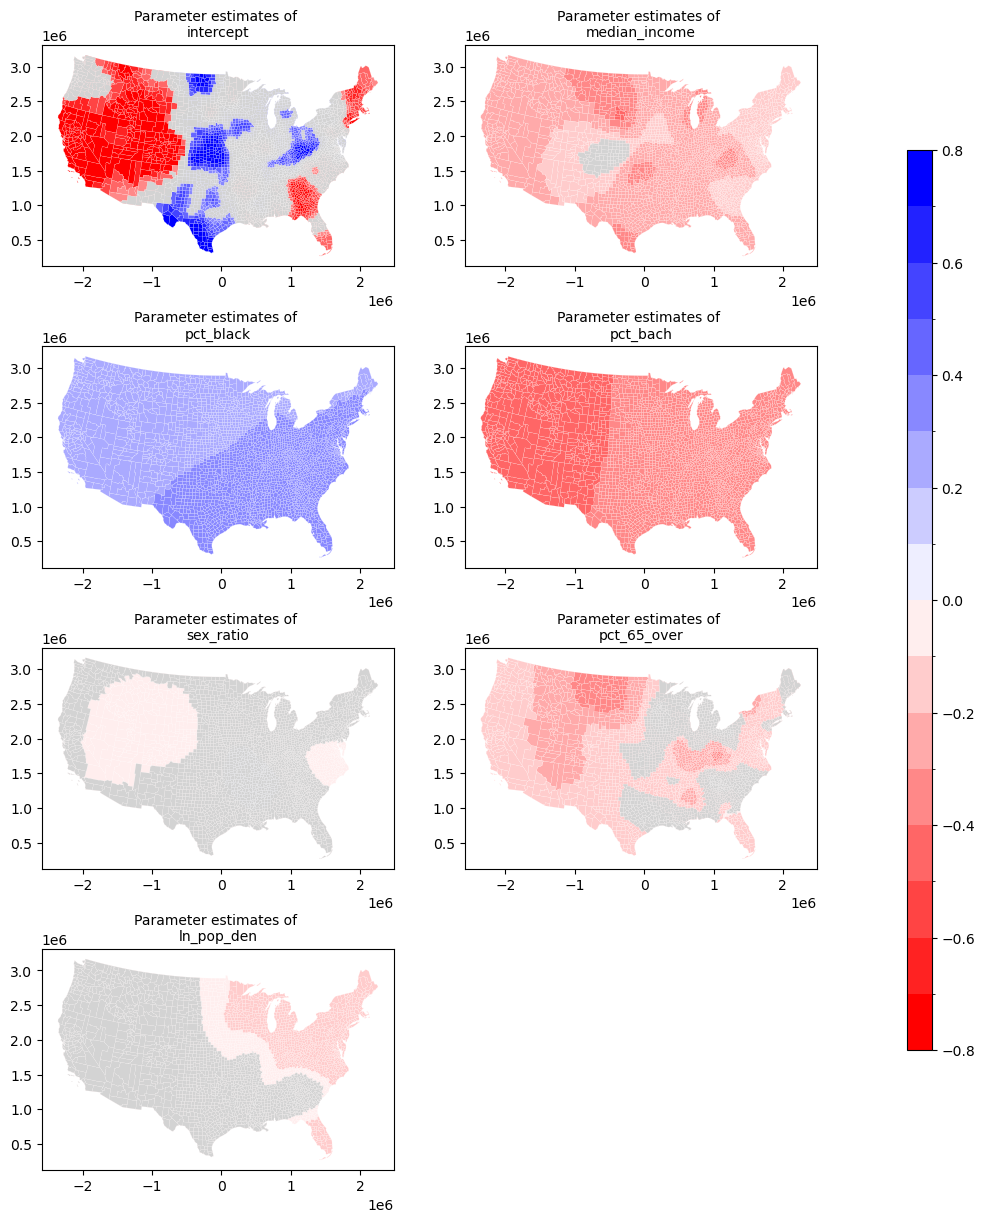

In [22]:
param_plots(mgwr_results, gdf_income_health, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

In the MGWR model, a different spatial pattern can be observed in the relationships that exist between obesity and socio-demographic variables.

It is evident from the maps above that there are varying relationships between obesity and socio-demographic variables in the USA, with these relationships exhibiting spatial clustering. For instance, while regions like the northern part of Florida and Georgia demonstrate a weak, yet significant, negative relationship, areas such as California and the Midwest display a strong negative relationship. Conversely, regions like Texas and Nebraska exhibit a positive and significant relationship. Moreover, numerous parts of the USA exhibit an insignificant relationship between obesity and socio-demographic variables.

The maps reveal a weak, significant negative relationship between obesity and the percentage of individuals with bachelor's degrees in the USA.

Furthermore, the analysis indicates a weak, yet significant, positive relationship between the percentage of Black individuals and obesity incidents in the southeastern region and eastern part of the US.

Additionally, the maps illustrate that while there is a negative relationship between median income and obesity, an insignificant relationship can be observed in the mid USA.

A Moran's I value close to zero, such as -0.015, suggests that there is no systematic spatial pattern in the dataset. This means that the variable being analyzed does not exhibit a clear trend of clustering or dispersion across space.

### GWR vs. MGWR

MGWR appears to be the better model as it has a higher R2, lower AICc, and lower Moran's I of residuals, suggesting better performance in terms of explaining variance, model fit, and accounting for spatial autocorrelation in the residuals.

| Metric    | GWR    | MGWR   |
| ----------| ----------- | ----------- |
| R2        | 0.801      |  0.81      |
| AICc      |  4525.86     | 4193.67     |
| Moran's I of residuals    | 0.064  | -0.015  |